 <p style = "font-size: 35px;font-weight: bold;text-align:center;color:#800000"> Ecosure BI KPI calculations </p>

<div>
    <img src = "http://upload.wikimedia.org/wikipedia/en/0/0c/Mu_Sigma_Logo.jpg" align="left" style="height:100px;margin-right:100px">
</div>
<div>
    <img src = "https://upload.wikimedia.org/wikipedia/commons/2/26/Ecolab.svg" align="right" style="height:40px;margin-left:100px; margin-top:25px">
</div>

<p style="font-size:100%;text-align:left;font-weight:bold"> Created by  : Mu Sigma team for Ecolab
<p style="font-size:100%;text-align:left;font-weight:bold;"> Last edited : 04/20/2021

 <p style = "font-size: 20px;font-weight: bold;text-align: left;color:#000000"> Description:   </p>
 
This notebook is used to explore the relationship between the drivers and measures. The data used for the notebook right now is dummy data. 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import pandas as pd
import numpy as np
import os
import warnings
import itertools
import datetime
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy import stats
import matplotlib
import seaborn as sns
import pytz
import pyodbc
utc=pytz.UTC
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)
pd.options.display.float_format = '{:.2f}'.format

Snap shot of Data

In [3]:
# ecosure db connetion parameters 

server = 'g360_idm_db_s.ecolab.com'
username = 'AravindV'
password = 'AravindV'
driver= '{ODBC Driver 17 for SQL Server}'
conn = pyodbc.connect('DRIVER='+driver+';SERVER=g360_idm_db_s.ecolab.com;DATABASE=Ecosure_BI;UID='+username+';PWD='+ password)

sql = '''SELECT DC.ClientID ,DC.ClientName ,DS.ServiceLocationID ,DS.UnitNbr ,DS.Address1 ,DS.Address2 ,DS.StoreName
        ,DS.City ,DS.StoreType ,DS.StoreStatus ,DS.Franchisee ,DS.ConceptName ,UPPER(DS.State) AS State ,DS.Country 
        ,DS.Zipcode
        ,DS.Latitude
        ,DS.Longitude
        ,DF.FormID
        ,DF.FormName
        ,DF.Version
        ,DA.AuditID
        ,DA.ReferenceNumber
        ,FQ.AuditType
        ,DA.AuditCycle
        ,DA.VisitNumber
        ,DA.AuditStarted
        ,DA.AuditEnded
        ,YEAR(DA.AuditStarted) AS CalenderYear
        ,Month(DA.AuditStarted) AS CalenderMonth
        ,DateName(mm,DA.AuditStarted) AS CalenderMonthName
        ,RPP.YearName
        ,RPP.YearNum  AS ReportingYear
        ,RPP.MonthName AS ReportingMonthName
        ,RPP.MonthNum AS ReportingMonth
        ,DA.AuditNotes
        ,FQ.Level1_Violations
        ,FQ.Level2_Violations
        ,FQ.Level3_Violations
        ,FQ.Level4_Violations
        ,FQ.Level5_Violations
        ,FQ.Level6_Violations
        ,FQ.Rating
        ,FQ.Score
        ,FQ.TimeOnSiteMI
        ,DA.DWActRecInd
        ,DA.PreviousAuditID
        ,DA.AuditOrder
        ,DA.AuditKey
        ,DS.ServiceLocationKey
        ,FQ.FormKey
        ,(FQ.Level1_Violations+FQ.Level2_Violations+FQ.Level3_Violations) AS NumUnAccept
        FROM HERO.Dim_Client DC (NOLOCK)
        INNER JOIN HERO.Dim_Store DS (NOLOCK)
        ON DC.ClientID = DS.ClientID
        AND DS.IsCurrentInd ='Y'
        AND DC.IsCurrentInd ='Y'
        INNER JOIN HERO.Dim_Audit DA (NOLOCK)
        ON DA.ServiceLocationID = DS.ServiceLocationID
        AND DA.IsCurrentInd  ='Y'
        AND DA.IsTestAudit =0
        AND DA.DWActRecInd='Y'
        AND DA.HDIAudit='N'
        
        INNER JOIN HERO.Fact_ESAudit FQ (NOLOCK)
        ON DA.AuditKey = FQ.AuditKey
        INNER JOIN HERO.Dim_ReportingPeriods RPP (NOLOCK)
        ON RPP.ReportingPeriodKey = FQ.ReportingPeriodKey
        AND RPP.IsCurrentInd ='Y' 
        
        INNER JOIN HERO.Dim_Form DF (NOLOCK)
        ON DF.FormID = DA.FormID
        AND DF.IsCurrentInd ='Y'
        WHERE DC.CLIENTID=2156'''

# sql = 'SHOW TABLES'
df_audit = pd.read_sql(sql, conn)
df_audit.head()

,ClientID,ClientName,ServiceLocationID,UnitNbr,Address1,Address2,StoreName,City,StoreType,StoreStatus,Franchisee,ConceptName,State,Country,Zipcode,Latitude,Longitude,FormID,FormName,Version,AuditID,ReferenceNumber,AuditType,AuditCycle,VisitNumber,AuditStarted,AuditEnded,CalenderYear,CalenderMonth,CalenderMonthName,YearName,ReportingYear,ReportingMonthName,ReportingMonth,AuditNotes,Level1_Violations,Level2_Violations,Level3_Violations,Level4_Violations,Level5_Violations,Level6_Violations,Rating,Score,TimeOnSiteMI,DWActRecInd,PreviousAuditID,AuditOrder,AuditKey,ServiceLocationKey,FormKey,NumUnAccept
0,2156,Modern Market,1342103,034,3260 S College Ave,#140,South College,Fort Collins,Unknown,Open,,Modern Market,CO,USA,80525,40.54,-105.08,1470,Modern Market Food Safety (S),2,5284199,MP-6020,None,4,1,2020-10-05 16:12:00,2020-10-05 17:59:25.187,2020,10,October,2020,2020,October,10,None,4,3,4,None,None,None,-1,67.00,107,Y,nan,2,9186340831180132209,3692295028274553397,-6498960579757550742,11
1,2156,Modern Market,1342103,034,3260 S College Ave,#140,South College,Fort Collins,Unknown,Open,,Modern Market,CO,USA,80525,40.54,-105.08,1470,Modern Market Food Safety (S),2,5333743,MP-6020,None,4,2,2020-11-12 08:15:00,2020-11-12 09:59:32.110,2020,11,November,2020,2020,November,11,None,0,0,2,None,None,None,-1,90.00,104,Y,5284199.00,1,-5567471522035199376,3692295028274553397,-6498960579757550742,2
2,2156,Modern Market,1342104,035,7170 N. Academy Blvd,,Academy,Colorado Springs,Unknown,Open,,Modern Market,CO,USA,80920,38.94,-104.80,1470,Modern Market Food Safety (S),2,5282079,MP-6020,None,4,1,2020-10-02 13:19:00,2020-10-02 14:56:37.877,2020,10,October,2020,2020,October,10,None,2,1,3,None,None,None,-1,80.00,97,Y,nan,1,-1963185638805087931,-4871417368993235857,-6498960579757550742,6
3,2156,Modern Market,1263658,024,4901 E Ray Road Suite 100,,Ahwatukee,Phoenix,,Open,,Modern Market,AZ,USA,85044,33.32,-111.98,1470,Modern Market Food Safety (S),2,4726772,MP-6020,None,1,1,2019-05-02 10:25:00,2019-05-02 12:32:12.080,2019,5,May,2019,2019,May,5,None,2,6,4,None,None,None,-1,60.00,127,Y,nan,8,-385613353749525663,817115121515340965,-6498960579757550742,12
4,2156,Modern Market,1263658,024,4901 E Ray Road Suite 100,,Ahwatukee,Phoenix,,Open,,Modern Market,AZ,USA,85044,33.32,-111.98,1470,Modern Market Food Safety (S),2,4834325,MP-6020,None,2,1,2019-07-29 12:59:00,2019-07-29 14:42:38.163,2019,7,July,2019,2019,July,7,None,2,1,6,None,None,None,-1,65.00,103,Y,4726772.00,7,2381287658059288561,817115121515340965,-6498960579757550742,9


In [4]:
print(df_audit.shape)
print('There are a total of 194 audits done for Modern Market')

(194, 51)
There are a total of 194 audits done for Modern Market


In [5]:
print(df_audit.Score.max())
print(df_audit.Score.min())

100.0
40.0


## No of violations & Avg audit score for Modern Market for each month 

- Level 1 is Minor Violation
- Level 2 is Major Violation
- Level 3 is Critical Violation

In [6]:
df_audit['AuditStarted'] = pd.to_datetime(df_audit['AuditStarted'], errors='coerce')
df_audit['Date'] = df_audit['AuditStarted'].dt.date

df_audit['month_year'] = df_audit['Date'].apply(lambda x: x.strftime('%B-%Y'))

In [7]:
df_violations = df_audit.groupby(['month_year'], as_index=False).agg({'Level1_Violations' : 'sum', 'Level2_Violations' : 'sum',
                                                                      'Level3_Violations' : 'sum', 'Score' : 'mean', 
                                                                      'ClientName' : 'count'})

In [8]:
df_violations.rename({'Level1_Violations' : 'Minor_Violations', 
                      'Level2_Violations' : 'Major_Violations',
                      'Level3_Violations' : 'Critical_Violations',
                      'Score' : 'Average_Audit_Score',
                      'ClientName' : 'No_of_Audits'},axis=1, inplace=True)

In [10]:
df_violations['Total_No_of_Violations'] = df_violations['Minor_Violations'] + df_violations['Major_Violations'] + df_violations['Critical_Violations']
df_violations['Average_Audit_Score_per_audit'] = df_violations['Average_Audit_Score']/df_violations['No_of_Audits']

In [11]:
df_violations['Minor_Violations_per_audit'] = df_violations['Minor_Violations']/df_violations['No_of_Audits']
df_violations['Major_Violations_per_audit'] = df_violations['Major_Violations']/df_violations['No_of_Audits']
df_violations['Critical_Violations_per_audit'] = df_violations['Critical_Violations']/df_violations['No_of_Audits']
df_violations['Total_No_of_Violations_per_audit'] = df_violations['Total_No_of_Violations']/df_violations['No_of_Audits']

In [13]:
df_violations.loc[-1] = ['March-2020', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
df_violations.loc[-1] = ['April-2020', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
df_violations.loc[-1] = ['May-2020', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

### Total No of Violation (Normalized by:No of of Audits)

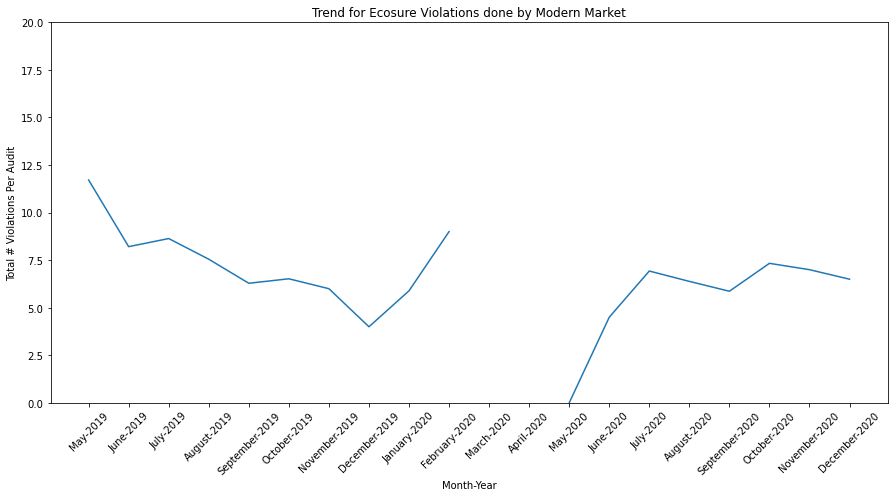

In [14]:
plt.figure(figsize=(15,7))

new_orders = ['May-2019', 'June-2019', 'July-2019', 'August-2019', 'September-2019', 'October-2019', 'November-2019', 'December-2019',
              'January-2020', 'February-2020', 'March-2020', 'April-2020', 'May-2020', 'June-2020', 'July-2020', 'August-2020',
              'September-2020', 'October-2020', 'November-2020', 'December-2020']

df_violations['month_year'] = pd.Categorical(df_violations['month_year'], categories=new_orders, ordered=True)
df_violations.sort_values(by=['month_year'], ascending=True, inplace=True)

ax = sns.lineplot(x='month_year', y='Total_No_of_Violations_per_audit', data=df_violations)
ax.set(xlabel = 'Month-Year', ylabel = 'Total # Violations Per Audit')
ax.set_title('Trend for Ecosure Violations done by Modern Market')
plt.xticks(rotation=45)
ax.set(ylim=(0,20))
plt.show()

### Average Audit Score (Normalized by:No of of Audits)

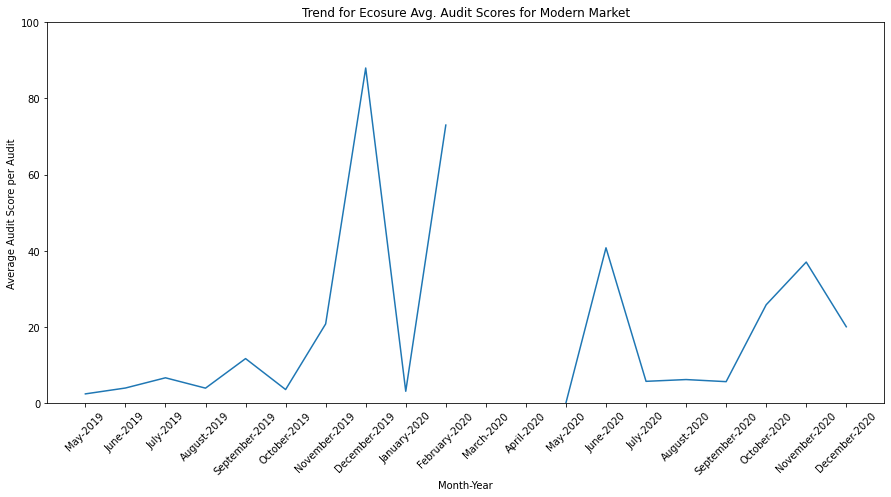

In [15]:
plt.figure(figsize=(15,7))

new_orders = ['May-2019', 'June-2019', 'July-2019', 'August-2019', 'September-2019', 'October-2019', 'November-2019', 'December-2019',
              'January-2020', 'February-2020', 'March-2020', 'April-2020', 'May-2020', 'June-2020', 'July-2020', 'August-2020',
              'September-2020', 'October-2020', 'November-2020', 'December-2020']

df_violations['month_year'] = pd.Categorical(df_violations['month_year'], categories=new_orders, ordered=True)
df_violations.sort_values(by=['month_year'], ascending=True, inplace=True)

 

ax = sns.lineplot(x='month_year', y='Average_Audit_Score_per_audit', data=df_violations)
ax.set(xlabel = 'Month-Year', ylabel = 'Average Audit Score per Audit')
ax.set_title('Trend for Ecosure Avg. Audit Scores for Modern Market')
ax.set(ylim=(0, 100))
plt.xticks(rotation=45)
plt.show()

### Different Type of Violations (Normalized by:No of of Audits)

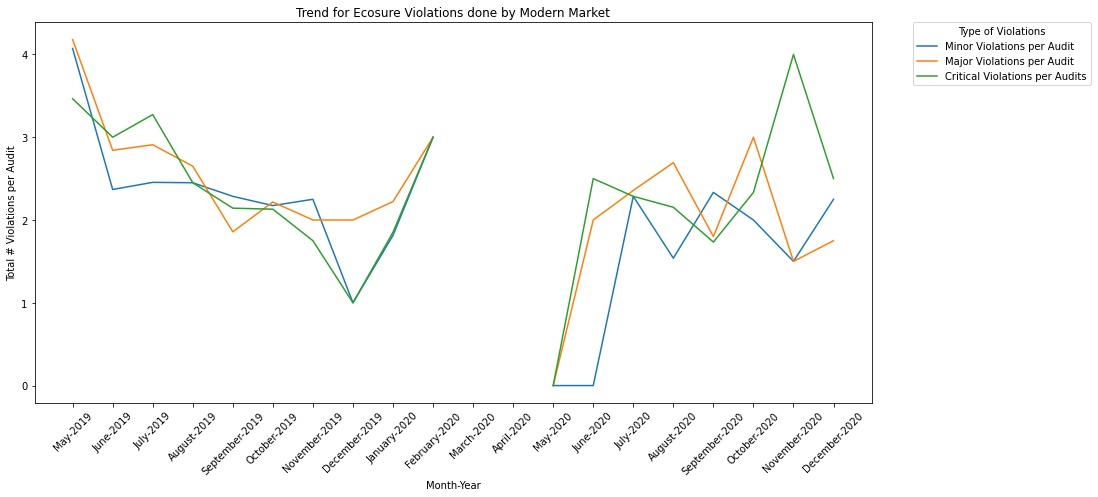

In [16]:
plt.figure(figsize=(15,7))

new_orders = ['May-2019', 'June-2019', 'July-2019', 'August-2019', 'September-2019', 'October-2019', 'November-2019', 'December-2019',
              'January-2020', 'February-2020', 'March-2020', 'April-2020', 'May-2020', 'June-2020', 'July-2020', 'August-2020',
              'September-2020', 'October-2020', 'November-2020', 'December-2020']

df_violations['month_year'] = pd.Categorical(df_violations['month_year'], categories=new_orders, ordered=True)
df_violations.sort_values(by=['month_year'], ascending=True, inplace=True)

 
ax = sns.lineplot(x='month_year', y='value', hue='variable', 
                  data=pd.melt(df_violations, id_vars=['month_year'], value_vars=['Minor_Violations_per_audit', 'Major_Violations_per_audit', 'Critical_Violations_per_audit']))
ax.set(xlabel = 'Month-Year', ylabel = 'Total # Violations per Audit')
ax.set_title('Trend for Ecosure Violations done by Modern Market')
plt.xticks(rotation=45)
new_labels = ['Minor Violations per Audit', 'Major Violations per Audit', 'Critical Violations per Audits']
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Type of Violations', labels=new_labels)
plt.show()

## Comparison with Review & Rating data for Modern Market from DataInfinity

### Preview of Review Data

In [17]:
df_review = pd.read_csv('./csv/Modern_Market.csv')
df_review = df_review.loc[:, ~df_review.columns.str.contains('^Unnamed')]
df_review.head()

,date,dateSeen,id,sourceURLs,text,username,rating,title,userCity,userProvince,Flair_Score,Sentiment_Type
0,2014-02-25T00:00:00.000Z,2021-03-07T10:36:52.581Z,530cbe8e11d2a9634fb20fda,['https://foursquare.com/v/modern-market/530b9...,Go to modmarket.com or their FB page to print ...,Ilya N.,nan,NaN,NaN,NaN,-1.00,Negative
1,2014-12-22T00:00:00Z,2015-12-16T00:00:00Z,NaN,['https://foursquare.com/v/modmarket/530b95ba4...,Healthy & yummy!,Lisa Cheeze,nan,NaN,NaN,NaN,1.00,Positive
2,2014-07-07T00:00:00Z,2015-12-16T00:00:00Z,NaN,['https://foursquare.com/v/modmarket/530b95ba4...,"Good, healthy food at a good price with a rece...",Kristyn Ulanday,nan,NaN,NaN,NaN,1.00,Positive
3,2019-07-27T00:00:00.000Z,2019-08-02T00:00:00Z,NaN,['https://www.yellowpages.com/denver-co/mip/mo...,Margharita Pizza was amazing. Loved the lemona...,Jo J,5.00,Deliciousness Abounds,NaN,NaN,1.00,Positive
4,2019-10-25T00:00:00.000Z,2020-02-24T04:14:43.641Z,NaN,['https://www.tripadvisor.com/Restaurant_Revie...,I got a Buddha Bowl to go - generous portion w...,CleopatraBunny,5.00,So fresh and healthy!,Flagstaff,NaN,1.00,Positive


In [18]:
df_review = df_review[df_review['date'].notnull()]
df_review.reset_index(drop=True, inplace=True)

df_review['Date'] = pd.to_datetime(df_review['date'], errors='coerce')
df_review['Date'] = df_review['Date'].dt.date

df_review['month_year'] = df_review['Date'].apply(lambda x: x.strftime('%B-%Y'))

In [19]:
print(df_review.shape)
print('\n')
print(df_review.rating.isna().sum())
print('\n')
print(df_review.rating.value_counts())

(473, 14)


185


5.00    134
4.00     96
3.00     25
1.00     17
2.00     16
Name: rating, dtype: int64


In [20]:
df_grouped_review = df_review.groupby(['month_year'], as_index=False).agg({'Flair_Score' : 'mean', 'rating' : 'mean', 'text' : 'count'})
df_grouped_review.rename({'text' : 'No_of_Reviews', 'rating' : 'Rating'}, axis=1, inplace=True)

In [21]:
df_merged = pd.merge(df_violations, df_grouped_review, how='left', on='month_year')
df_merged.fillna(0, inplace=True)

In [22]:
df_merged.columns

Index(['month_year', 'Minor_Violations', 'Major_Violations', 'Critical_Violations', 'Average_Audit_Score', 'No_of_Audits', 'Total_No_of_Violations', 'Average_Audit_Score_per_audit', 'Minor_Violations_per_audit', 'Major_Violations_per_audit', 'Critical_Violations_per_audit', 'Total_No_of_Violations_per_audit', 'Flair_Score', 'Rating', 'No_of_Reviews'], dtype='object')

### No of Reviews available for Each Month

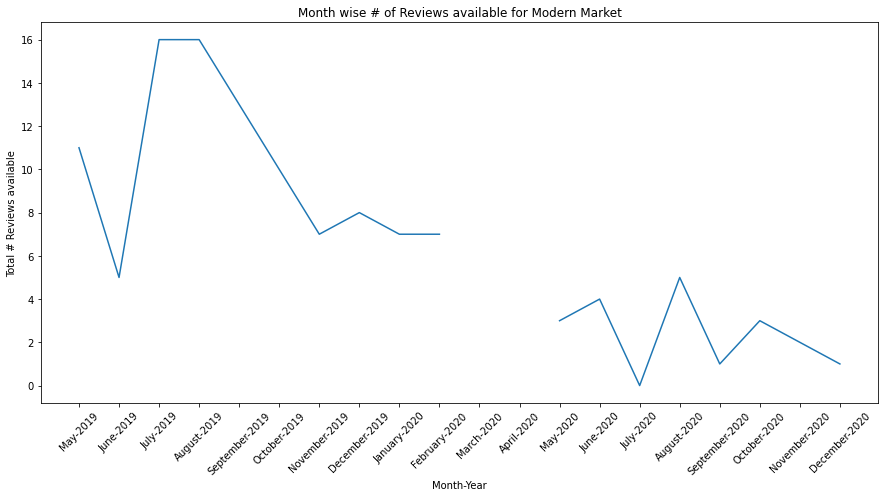

In [23]:
plt.figure(figsize=(15,7))

new_orders = ['May-2019', 'June-2019', 'July-2019', 'August-2019', 'September-2019', 'October-2019', 'November-2019', 'December-2019',
              'January-2020', 'February-2020', 'March-2020', 'April-2020', 'May-2020', 'June-2020', 'July-2020', 'August-2020',
              'September-2020', 'October-2020', 'November-2020', 'December-2020']

df_violations['month_year'] = pd.Categorical(df_violations['month_year'], categories=new_orders, ordered=True)
df_violations.sort_values(by=['month_year'], ascending=True, inplace=True)

df_merged['month_year'] = pd.Categorical(df_merged['month_year'], categories=new_orders, ordered=True)
df_merged.sort_values(by=['month_year'], ascending=True, inplace=True) 

ax = sns.lineplot(x='month_year', y='No_of_Reviews', data=df_merged)
ax.set(xlabel = 'Month-Year', ylabel = 'Total # Reviews available')
ax.set_title('Month wise # of Reviews available for Modern Market')
plt.xticks(rotation=45)
plt.show()

### Total No of Violations (Normalized By: No of Audit) trend compared with Review Sentiment trend

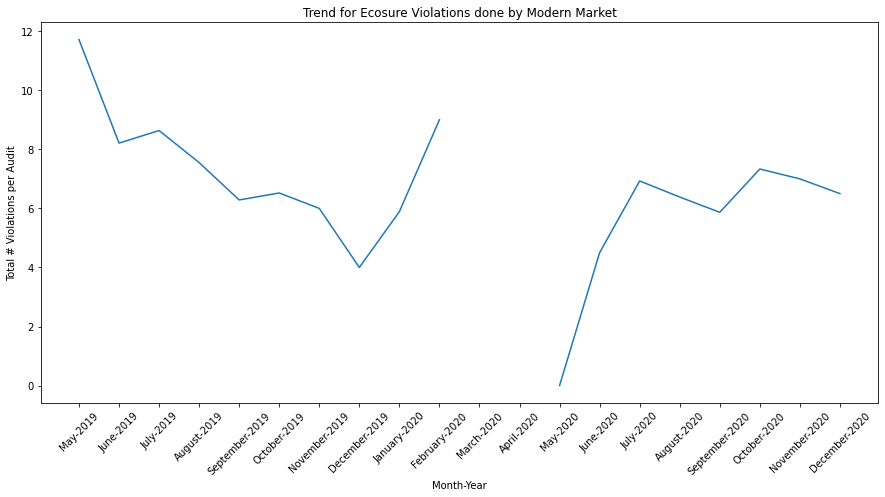

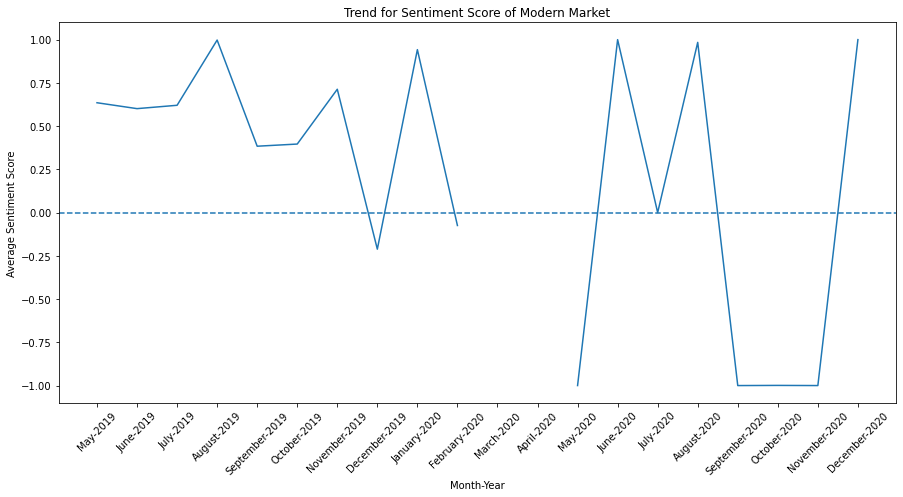

In [24]:
plt.figure(figsize=(15,7))

new_orders = ['May-2019', 'June-2019', 'July-2019', 'August-2019', 'September-2019', 'October-2019', 'November-2019', 'December-2019',
              'January-2020', 'February-2020', 'March-2020', 'April-2020', 'May-2020', 'June-2020', 'July-2020', 'August-2020',
              'September-2020', 'October-2020', 'November-2020', 'December-2020']

df_violations['month_year'] = pd.Categorical(df_violations['month_year'], categories=new_orders, ordered=True)
df_violations.sort_values(by=['month_year'], ascending=True, inplace=True)

df_merged['month_year'] = pd.Categorical(df_merged['month_year'], categories=new_orders, ordered=True)
df_merged.sort_values(by=['month_year'], ascending=True, inplace=True) 

ax = sns.lineplot(x='month_year', y='Total_No_of_Violations_per_audit', data=df_violations)
ax.set(xlabel = 'Month-Year', ylabel = 'Total # Violations per Audit')
ax.set_title('Trend for Ecosure Violations done by Modern Market')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(15,7))
ax = sns.lineplot(x='month_year', y='Flair_Score', data=df_merged)
ax.set(xlabel = 'Month-Year', ylabel = 'Average Sentiment Score')
ax.set_title('Trend for Sentiment Score of Modern Market')
ax.axhline(0, ls='--')
plt.xticks(rotation=45)

plt.show()

### Total No of Violations (Normalized By: No of Audit) trend compared with Rating trend

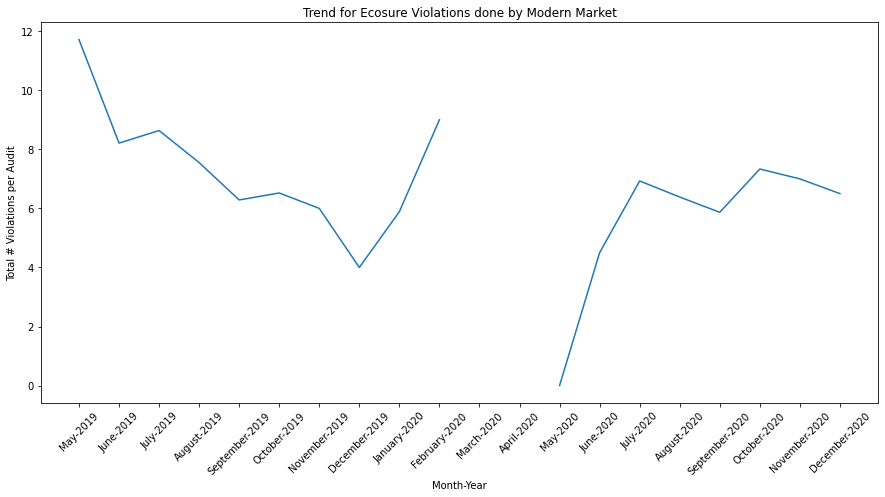

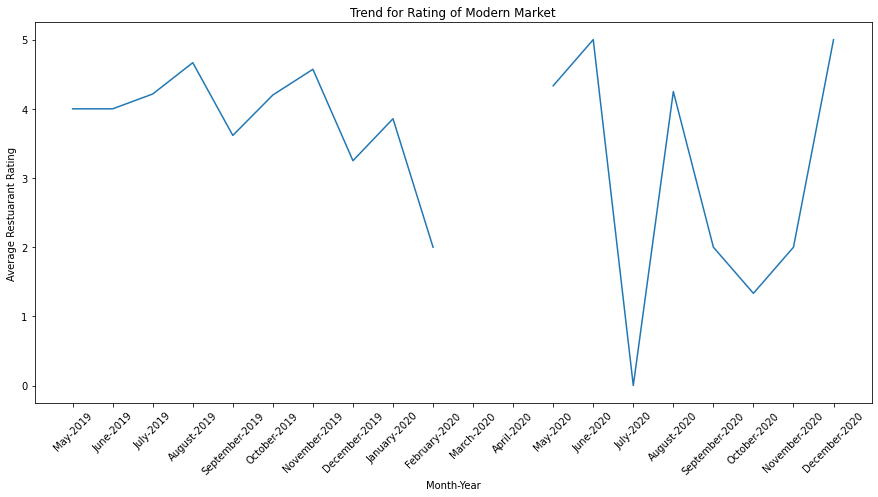

In [25]:
plt.figure(figsize=(15,7))

new_orders = ['May-2019', 'June-2019', 'July-2019', 'August-2019', 'September-2019', 'October-2019', 'November-2019', 'December-2019',
              'January-2020', 'February-2020', 'March-2020', 'April-2020', 'May-2020', 'June-2020', 'July-2020', 'August-2020',
              'September-2020', 'October-2020', 'November-2020', 'December-2020']

df_violations['month_year'] = pd.Categorical(df_violations['month_year'], categories=new_orders, ordered=True)
df_violations.sort_values(by=['month_year'], ascending=True, inplace=True)

df_merged['month_year'] = pd.Categorical(df_merged['month_year'], categories=new_orders, ordered=True)
df_merged.sort_values(by=['month_year'], ascending=True, inplace=True) 

ax = sns.lineplot(x='month_year', y='Total_No_of_Violations_per_audit', data=df_violations)
ax.set(xlabel = 'Month-Year', ylabel = 'Total # Violations per Audit')
ax.set_title('Trend for Ecosure Violations done by Modern Market')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(15,7))
ax = sns.lineplot(x='month_year', y='Rating', data=df_merged)
ax.set(xlabel = 'Month-Year', ylabel = 'Average Restuarant Rating')
ax.set_title('Trend for Rating of Modern Market')
# ax.axhline(0, ls='--')
plt.xticks(rotation=45)

plt.show()

### Different Type of Violations (Normalized By:No of Audit) trend compared with Review Sentiment trend

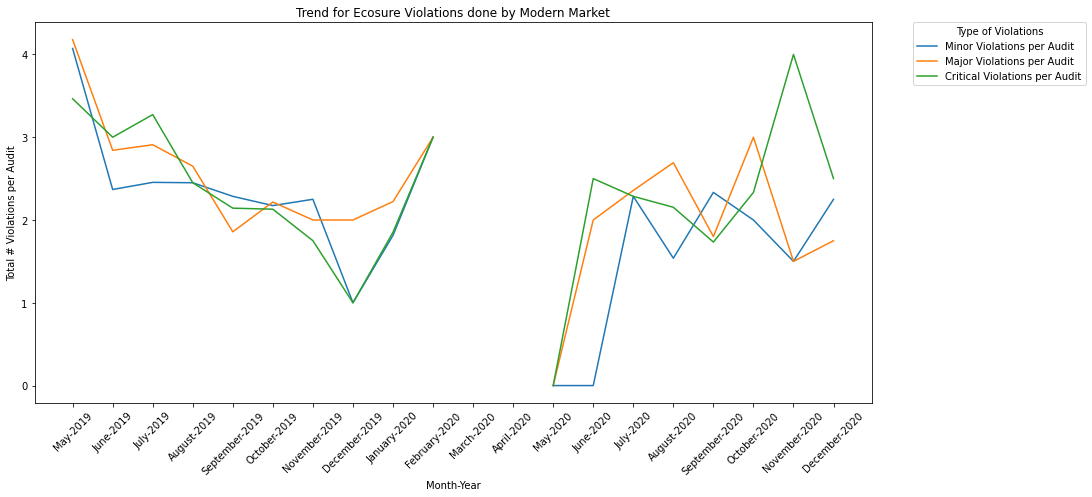

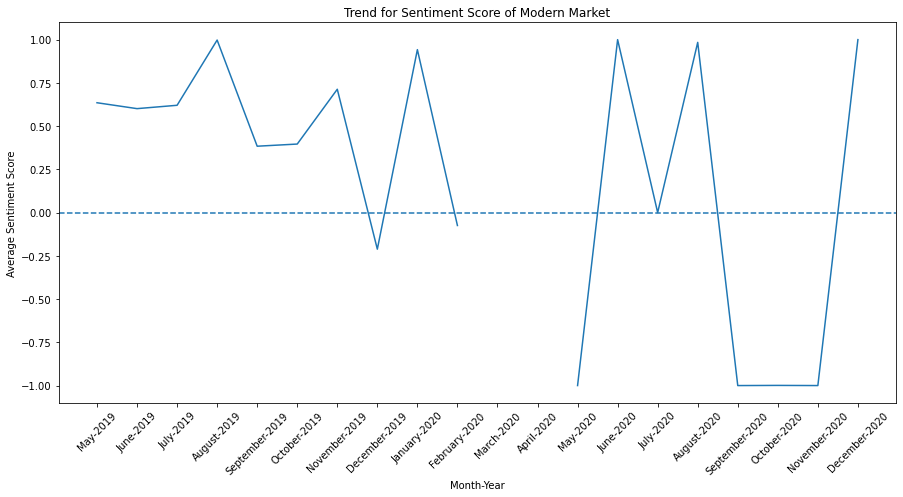

In [26]:
plt.figure(figsize=(15,7))

new_orders = ['May-2019', 'June-2019', 'July-2019', 'August-2019', 'September-2019', 'October-2019', 'November-2019', 'December-2019',
              'January-2020', 'February-2020', 'March-2020', 'April-2020', 'May-2020', 'June-2020', 'July-2020', 'August-2020',
              'September-2020', 'October-2020', 'November-2020', 'December-2020']

df_violations['month_year'] = pd.Categorical(df_violations['month_year'], categories=new_orders, ordered=True)
df_violations.sort_values(by=['month_year'], ascending=True, inplace=True)

df_merged['month_year'] = pd.Categorical(df_merged['month_year'], categories=new_orders, ordered=True)
df_merged.sort_values(by=['month_year'], ascending=True, inplace=True) 

ax = sns.lineplot(x='month_year', y='value', hue='variable', 
                  data=pd.melt(df_violations, id_vars=['month_year'], value_vars=['Minor_Violations_per_audit', 'Major_Violations_per_audit', 'Critical_Violations_per_audit']))
ax.set(xlabel = 'Month-Year', ylabel = 'Total # Violations per Audit')
ax.set_title('Trend for Ecosure Violations done by Modern Market')
plt.xticks(rotation=45)
new_labels = ['Minor Violations per Audit', 'Major Violations per Audit', 'Critical Violations per Audit']
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Type of Violations', labels=new_labels)
plt.show()

plt.figure(figsize=(15,7))
ax = sns.lineplot(x='month_year', y='Flair_Score', data=df_merged)
ax.set(xlabel = 'Month-Year', ylabel = 'Average Sentiment Score')
ax.set_title('Trend for Sentiment Score of Modern Market')
ax.axhline(0, ls='--')
plt.xticks(rotation=45)

plt.show()

### Different Type of Violations (Normalized By: No of Audits) trend compared with Rating trend

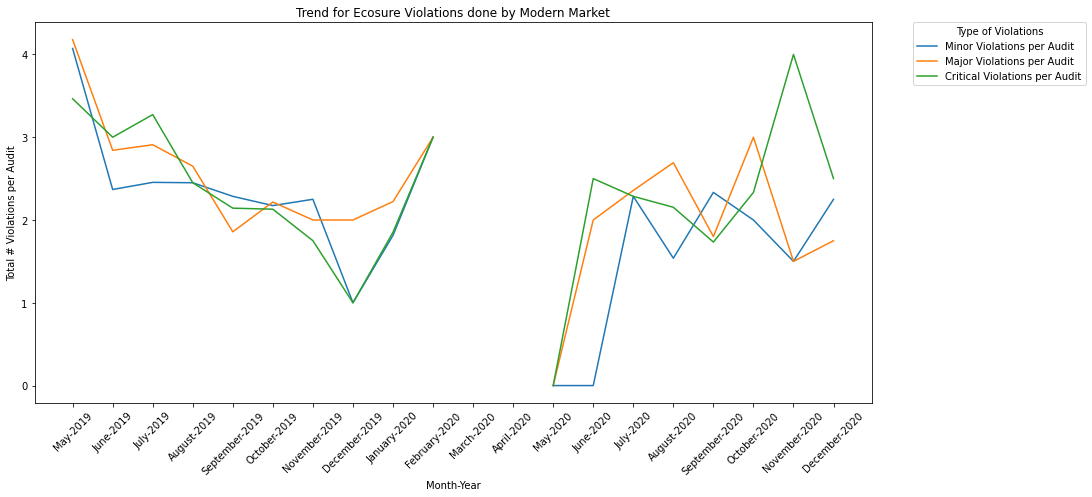

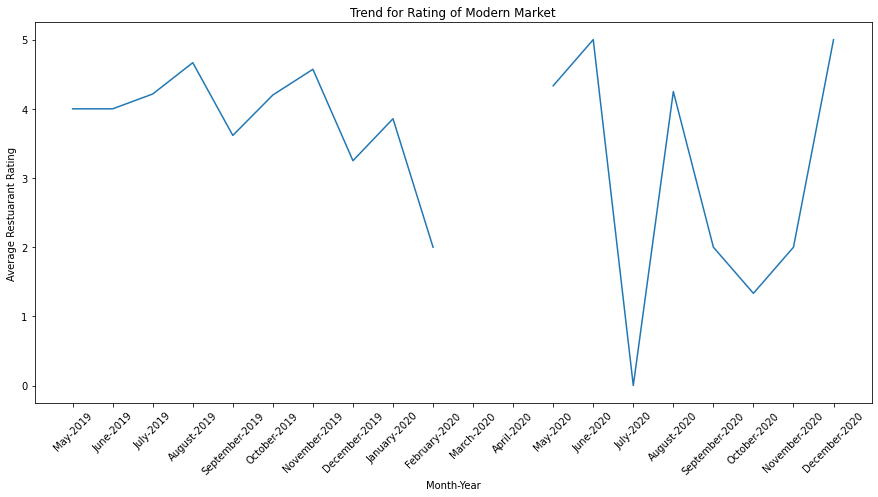

In [27]:
plt.figure(figsize=(15,7))

new_orders = ['May-2019', 'June-2019', 'July-2019', 'August-2019', 'September-2019', 'October-2019', 'November-2019', 'December-2019',
              'January-2020', 'February-2020', 'March-2020', 'April-2020', 'May-2020', 'June-2020', 'July-2020', 'August-2020',
              'September-2020', 'October-2020', 'November-2020', 'December-2020']

df_violations['month_year'] = pd.Categorical(df_violations['month_year'], categories=new_orders, ordered=True)
df_violations.sort_values(by=['month_year'], ascending=True, inplace=True)

df_merged['month_year'] = pd.Categorical(df_merged['month_year'], categories=new_orders, ordered=True)
df_merged.sort_values(by=['month_year'], ascending=True, inplace=True) 

ax = sns.lineplot(x='month_year', y='value', hue='variable', 
                  data=pd.melt(df_violations, id_vars=['month_year'], value_vars=['Minor_Violations_per_audit', 'Major_Violations_per_audit', 'Critical_Violations_per_audit']))
ax.set(xlabel = 'Month-Year', ylabel = 'Total # Violations per Audit')
ax.set_title('Trend for Ecosure Violations done by Modern Market')
plt.xticks(rotation=45)
new_labels = ['Minor Violations per Audit', 'Major Violations per Audit', 'Critical Violations per Audit']
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Type of Violations', labels=new_labels)
plt.show()

plt.figure(figsize=(15,7))
ax = sns.lineplot(x='month_year', y='Rating', data=df_merged)
ax.set(xlabel = 'Month-Year', ylabel = 'Average Restuarant Rating')
ax.set_title('Trend for Rating of Modern Market')
# ax.axhline(0, ls='--')
plt.xticks(rotation=45)

plt.show()

### Average Audit Score trend (Normalized By: No of audits) compared with Review Sentiment trend

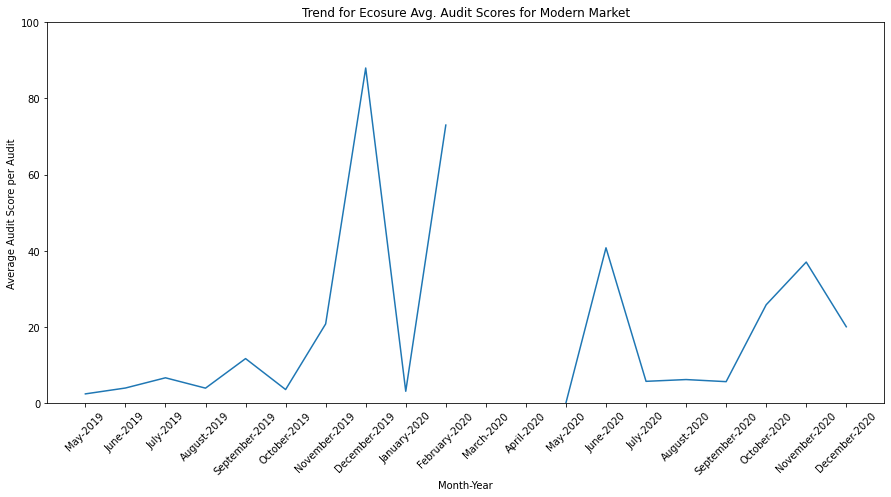

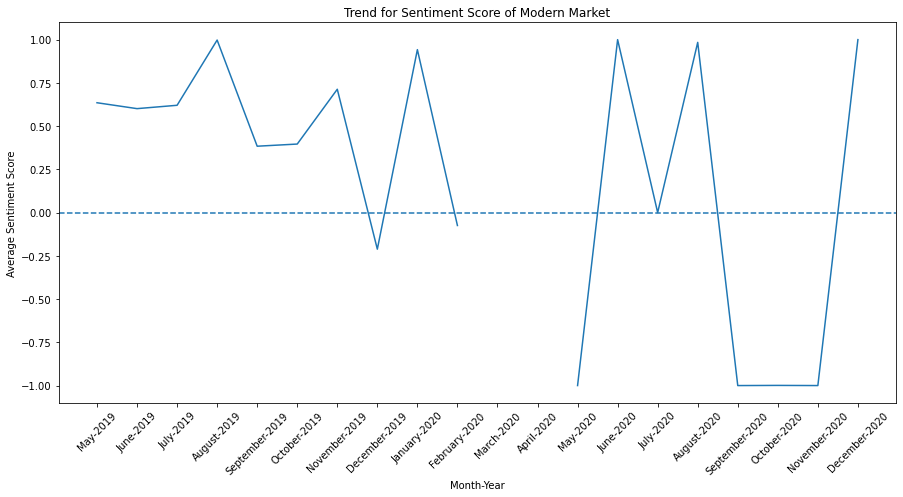

In [29]:
plt.figure(figsize=(15,7))

new_orders = ['May-2019', 'June-2019', 'July-2019', 'August-2019', 'September-2019', 'October-2019', 'November-2019', 'December-2019',
              'January-2020', 'February-2020', 'March-2020', 'April-2020', 'May-2020', 'June-2020', 'July-2020', 'August-2020',
              'September-2020', 'October-2020', 'November-2020', 'December-2020']

df_violations['month_year'] = pd.Categorical(df_violations['month_year'], categories=new_orders, ordered=True)
df_violations.sort_values(by=['month_year'], ascending=True, inplace=True)

df_merged['month_year'] = pd.Categorical(df_merged['month_year'], categories=new_orders, ordered=True)
df_merged.sort_values(by=['month_year'], ascending=True, inplace=True) 

ax = sns.lineplot(x='month_year', y='Average_Audit_Score_per_audit', data=df_violations)
ax.set(xlabel = 'Month-Year', ylabel = 'Average Audit Score per Audit')
ax.set_title('Trend for Ecosure Avg. Audit Scores for Modern Market')
ax.set(ylim=(0, 100))
plt.xticks(rotation=45)

plt.figure(figsize=(15,7))
ax = sns.lineplot(x='month_year', y='Flair_Score', data=df_merged)
ax.set(xlabel = 'Month-Year', ylabel = 'Average Sentiment Score')
ax.set_title('Trend for Sentiment Score of Modern Market')
ax.axhline(0, ls='--')
plt.xticks(rotation=45)

plt.show()

### Average Audit Score trend (Normalized By: No of Audit) compared with Rating trend

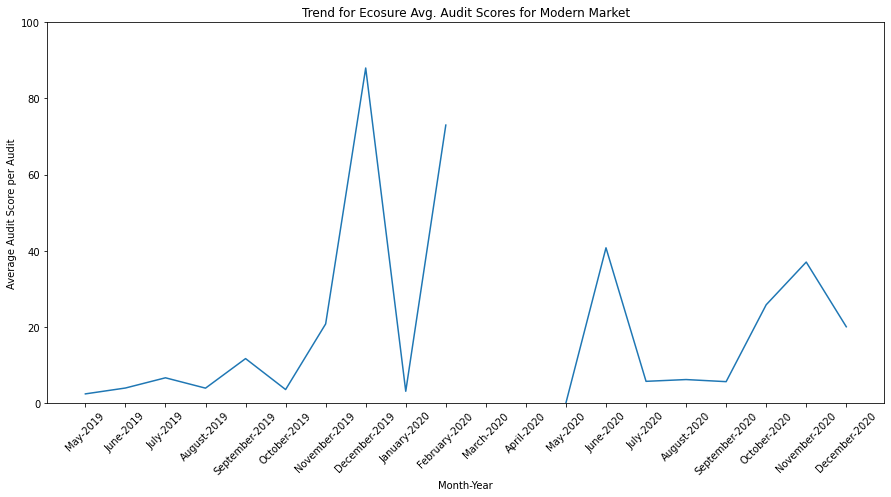

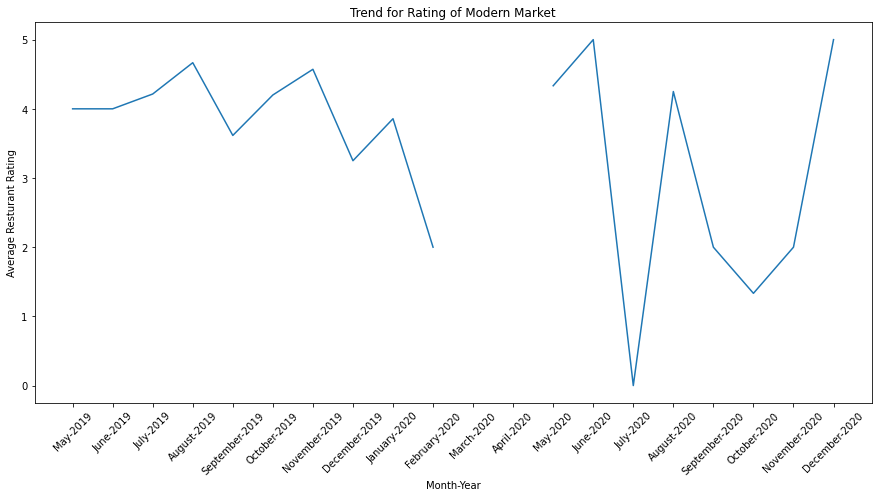

In [30]:
plt.figure(figsize=(15,7))

new_orders = ['May-2019', 'June-2019', 'July-2019', 'August-2019', 'September-2019', 'October-2019', 'November-2019', 'December-2019',
              'January-2020', 'February-2020', 'March-2020', 'April-2020', 'May-2020', 'June-2020', 'July-2020', 'August-2020',
              'September-2020', 'October-2020', 'November-2020', 'December-2020']

df_violations['month_year'] = pd.Categorical(df_violations['month_year'], categories=new_orders, ordered=True)
df_violations.sort_values(by=['month_year'], ascending=True, inplace=True)

df_merged['month_year'] = pd.Categorical(df_merged['month_year'], categories=new_orders, ordered=True)
df_merged.sort_values(by=['month_year'], ascending=True, inplace=True) 

ax = sns.lineplot(x='month_year', y='Average_Audit_Score_per_audit', data=df_violations)
ax.set(xlabel = 'Month-Year', ylabel = 'Average Audit Score per Audit')
ax.set_title('Trend for Ecosure Avg. Audit Scores for Modern Market')
ax.set(ylim=(0, 100))
plt.xticks(rotation=45)

plt.figure(figsize=(15,7))
ax = sns.lineplot(x='month_year', y='Rating', data=df_merged)
ax.set(xlabel = 'Month-Year', ylabel = 'Average Resturant Rating')
ax.set_title('Trend for Rating of Modern Market')
# ax.axhline(0, ls='--')
plt.xticks(rotation=45)

plt.show()

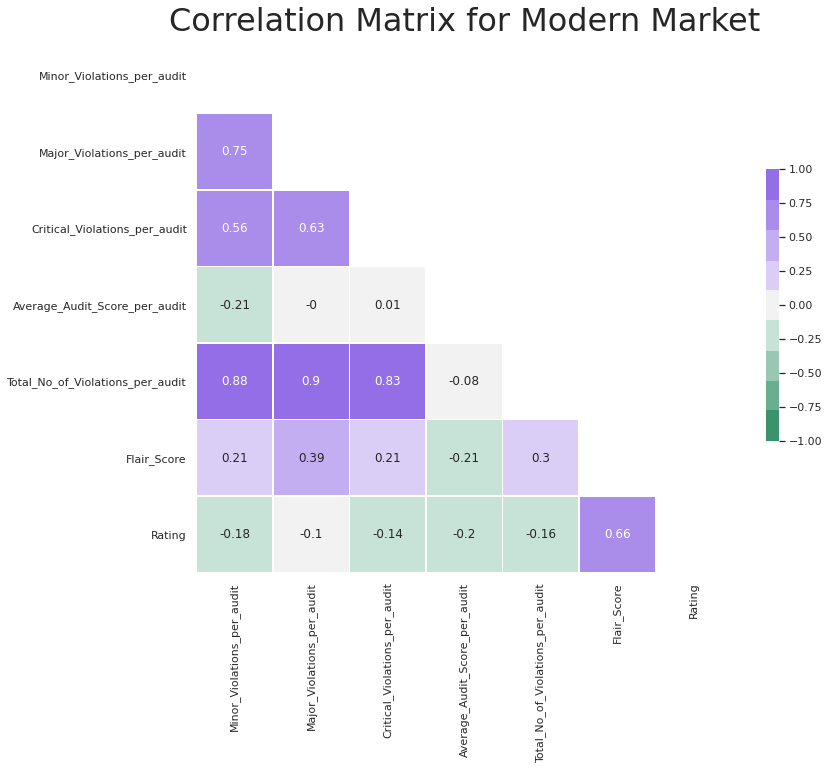

In [32]:
sns.set(style="white")

# Compute the correlation matrix
corr_data = df_merged[['Minor_Violations_per_audit', 'Major_Violations_per_audit', 'Critical_Violations_per_audit',
                       'Average_Audit_Score_per_audit', 'Total_No_of_Violations_per_audit', 'Flair_Score', 'Rating']]
corr = corr_data.corr()
corr = corr.round(2)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))
# Generate a custom diverging colormap
# cmap = sns.diverging_palette(220, 10, as_cmap=True)
cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
            annot = True, vmin=-1)
title = "Correlation Matrix for Modern Market"
ax.set_title(title, fontsize=32)
plt.show()

## Scatter plot Sentiment Score vs Total No of Violations per Audit

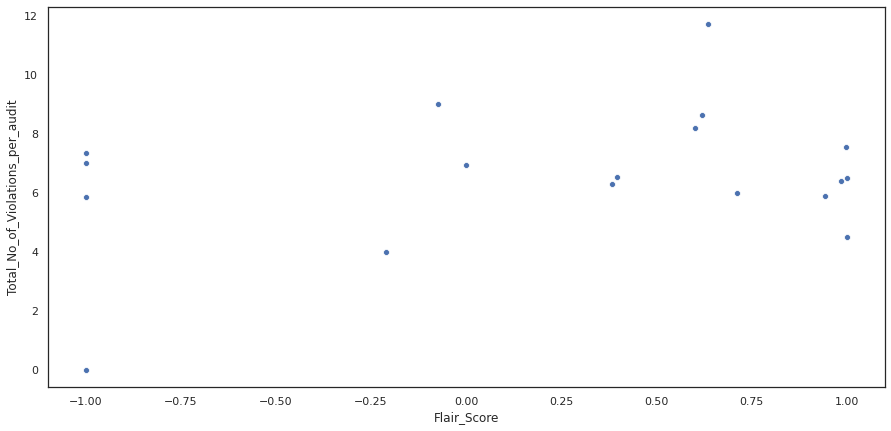

In [33]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=df_merged, x="Flair_Score", y="Total_No_of_Violations_per_audit")
plt.show()

## Scatter plot Ratings vs Total No of Violations per Audit

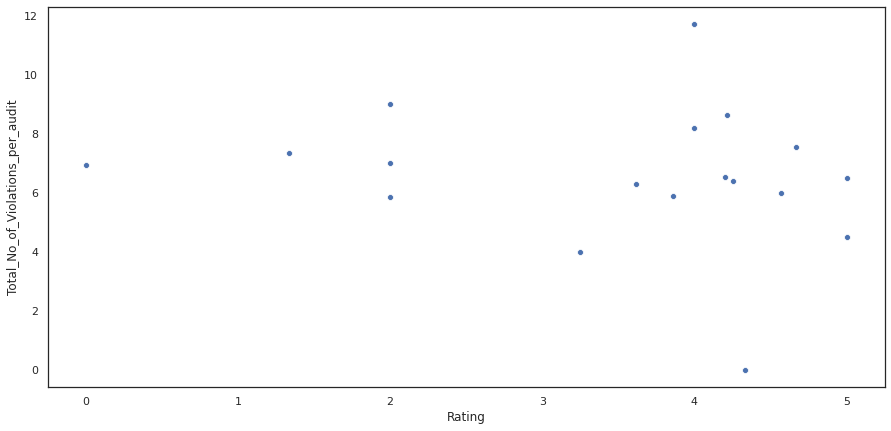

In [34]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=df_merged, x="Rating", y="Total_No_of_Violations_per_audit")
plt.show()

## Scatter plot Sentiment Score vs Average Audit Score

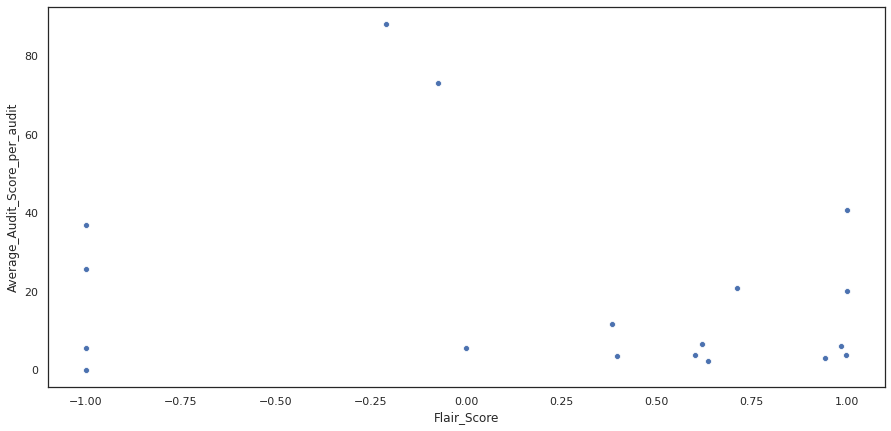

In [35]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=df_merged, x="Flair_Score", y="Average_Audit_Score_per_audit")
plt.show()

## Scatter plot Ratings vs Average Audit Score

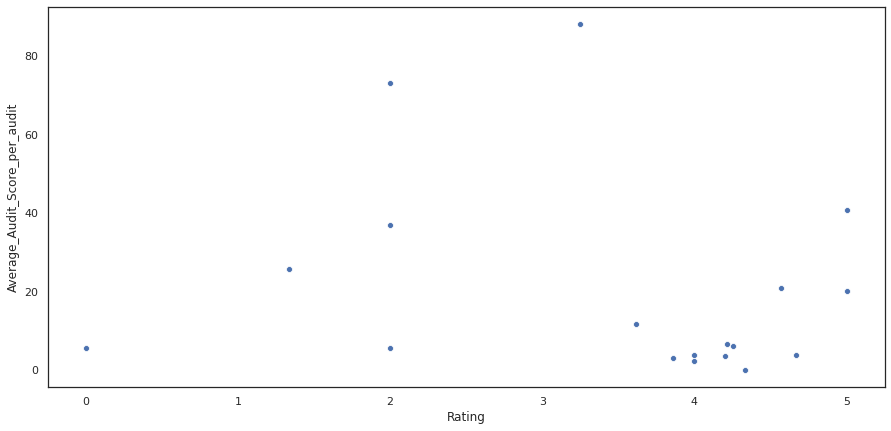

In [36]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=df_merged, x="Rating", y="Average_Audit_Score_per_audit")
plt.show()

## Hypothesis Testing 

In [37]:
def spearman_corr(df_datagrouped, test_var, measure):
    '''
    This functions returns a table with spearman hypothesis
    test results
    '''

    brands = ['Modern Market']
    spearman_corr = []
    null_hypothesis = []
    alternate_hypothsesis = []
    p_val = []

    for brand in brands:
        df_brandwise = df_datagrouped
        corr, pval = spearmanr(df_brandwise[test_var],
                            df_brandwise[measure])
        
        spearman_corr.append(corr)
        p_val.append(pval)
        
        # Accpeted and Rejected interchanged
        if pval < 0.05:
            null_hypothesis.append('Rejected')
            alternate_hypothsesis.append('Accepted')
        else:
            null_hypothesis.append('Accepted')
            alternate_hypothsesis.append('Rejected')

    test_df = pd.DataFrame({'Brand Name': brands,
                            'Spearman Coefficient': spearman_corr,
                            'p-value': p_val,
                            'Null Hypothesis': null_hypothesis,
                            'Atlernate Hypothesis': alternate_hypothsesis})
    
    return test_df

def one_way_anova(df_datagrouped, test_var):
    '''
    This functions returns a table with anova hypothesis
    test results
    '''
    brands = list(set(df_datagrouped['brand']))
    anova_dict = {}
    f_stat = []
    null_hypothesis = []
    alternate_hypothsesis = []
    p_val = []

    for brand in brands:
        df_brandwise = df_datagrouped[df_datagrouped.brand == brand]
        anova_dict['Positive'] = df_brandwise[test_var][df_brandwise.sentiment == 'Positive']
        anova_dict['Negative'] = df_brandwise[test_var][df_brandwise.sentiment == 'Negative']
        fstat, pval = stats.f_oneway(anova_dict['Positive'], anova_dict['Negative'])
        
        # Modifications for illustrative purposes
        fstat = random.uniform(4,6)
        pval = random.uniform(0,0.05)
        
        f_stat.append(fstat)
        p_val.append(pval)
        if pval < 0.05:
            null_hypothesis.append('Rejected')
            alternate_hypothsesis.append('Accepted')
        else:
            null_hypothesis.append('Accepted')
            alternate_hypothsesis.append('Rejected')

    test_df = pd.DataFrame({'Brand Name': brands,
                            'F-Statistic': f_stat,
                            'p-value': p_val,
                            'Null Hypothesis': null_hypothesis,
                            'Atlernate Hypothesis': alternate_hypothsesis})
    
    return test_df

### Hypothesis 1: Total No of Violations per Audit
<br>
<b>Null Hypothesis:</b> Increase in Total No of Violations per Audit does not affect sentiment scores
 
<b>Alternate Hypothesis:</b> Increase in Total No of Violations per Audit, results in decrease in sentiment scores

<b>Spearman Correlation Coefficient</b>

In [38]:
spearman_corr(df_merged, 'Total_No_of_Violations_per_audit', 'Flair_Score')

,Brand Name,Spearman Coefficient,p-value,Null Hypothesis,Atlernate Hypothesis
0,Modern Market,0.08,0.74,Accepted,Rejected


### Hypothesis 1: Total No of Violations per Audit
<br>
<b>Null Hypothesis:</b> Increase in Total No of Violations per Audit does not affect rating
 
<b>Alternate Hypothesis:</b> Increase in Total No of Violations per Audit, results in decrease in rating

In [39]:
spearman_corr(df_merged, 'Total_No_of_Violations_per_audit', 'Rating')

,Brand Name,Spearman Coefficient,p-value,Null Hypothesis,Atlernate Hypothesis
0,Modern Market,-0.20,0.42,Accepted,Rejected


### Hypothesis 2: Audit Scores
<br>
<b>Null Hypothesis:</b> Increase in Avg audit scores does not affect sentiment scores
 
<b>Alternate Hypothesis:</b> Increase in Avg audit scores, results in increase in sentiment scores

In [40]:
spearman_corr(df_merged, 'Average_Audit_Score_per_audit', 'Flair_Score')

,Brand Name,Spearman Coefficient,p-value,Null Hypothesis,Atlernate Hypothesis
0,Modern Market,-0.10,0.69,Accepted,Rejected


### Hypothesis 2: Audit Scores
<br>
<b>Null Hypothesis:</b> Increase in Avg audit scores does not affect ratings
 
<b>Alternate Hypothesis:</b> Increase in Avg audit scores, results in increase in ratings

In [41]:
spearman_corr(df_merged, 'Average_Audit_Score_per_audit', 'Rating')

,Brand Name,Spearman Coefficient,p-value,Null Hypothesis,Atlernate Hypothesis
0,Modern Market,-0.18,0.47,Accepted,Rejected
